In [1]:

import arviz as az
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn




<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education-categorical",
        "educ",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "captial-gain",
        "capital-loss",
        "hours",
        "native-country",
        "income",
    ],
)

In [3]:
raw_data.head(10)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## Подготовим данные

In [4]:
data = raw_data[~pd.isnull(raw_data["income"])]


In [5]:
data[data["native-country"] == " United-States"].sample(5)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
1282,65,?,36039,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States,>50K
24949,36,?,187983,HS-grad,9,Never-married,?,Unmarried,White,Female,0,0,40,United-States,<=50K
20135,38,Private,217349,Assoc-voc,11,Divorced,Prof-specialty,Not-in-family,White,Female,14344,0,40,United-States,>50K
23230,48,Federal-gov,100067,Some-college,10,Widowed,Other-service,Unmarried,Black,Female,0,0,40,United-States,<=50K
17940,30,Private,128065,Some-college,10,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,45,United-States,<=50K


In [6]:
income = 1 * (data["income"] == " >50K")

In [7]:
data = data[["age", "educ", "hours","marital-status"]]

# Scale age by 10, it helps with model convergence.
data["age"] = data["age"] / 10.0
data["age2"] = np.square(data["age"])
data["income"] = income

income.value_counts()

income
0    24720
1     7841
Name: count, dtype: int64

In [8]:
def replace_marital(marital):
    if 'married' in marital.lower():
        return 4
    elif 'single' in marital.lower():
        return 3
    elif 'divorced' in marital.lower():
        return 2
    elif 'unknown' in marital.lower():
        return 1
    
data['marital'] = data["marital-status"].apply(lambda x: replace_marital(x))

data['marital'].fillna(1, inplace=True)

In [9]:
data.head()

,age,educ,hours,marital-status,age2,income,marital
0,3.9,13,40,Never-married,15.21,0,4.0
1,5.0,13,13,Married-civ-spouse,25.00,0,4.0
2,3.8,9,40,Divorced,14.44,0,2.0
3,5.3,7,40,Married-civ-spouse,28.09,0,4.0
4,2.8,13,40,Married-civ-spouse,7.84,0,4.0


The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
C:\Users\anzel\AppData\Local\Temp\ipykernel_20316\98649366.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [educ, marital, age2, age, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2394 seconds.
c:\Users\anzel\anaconda3\envs\envpymc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


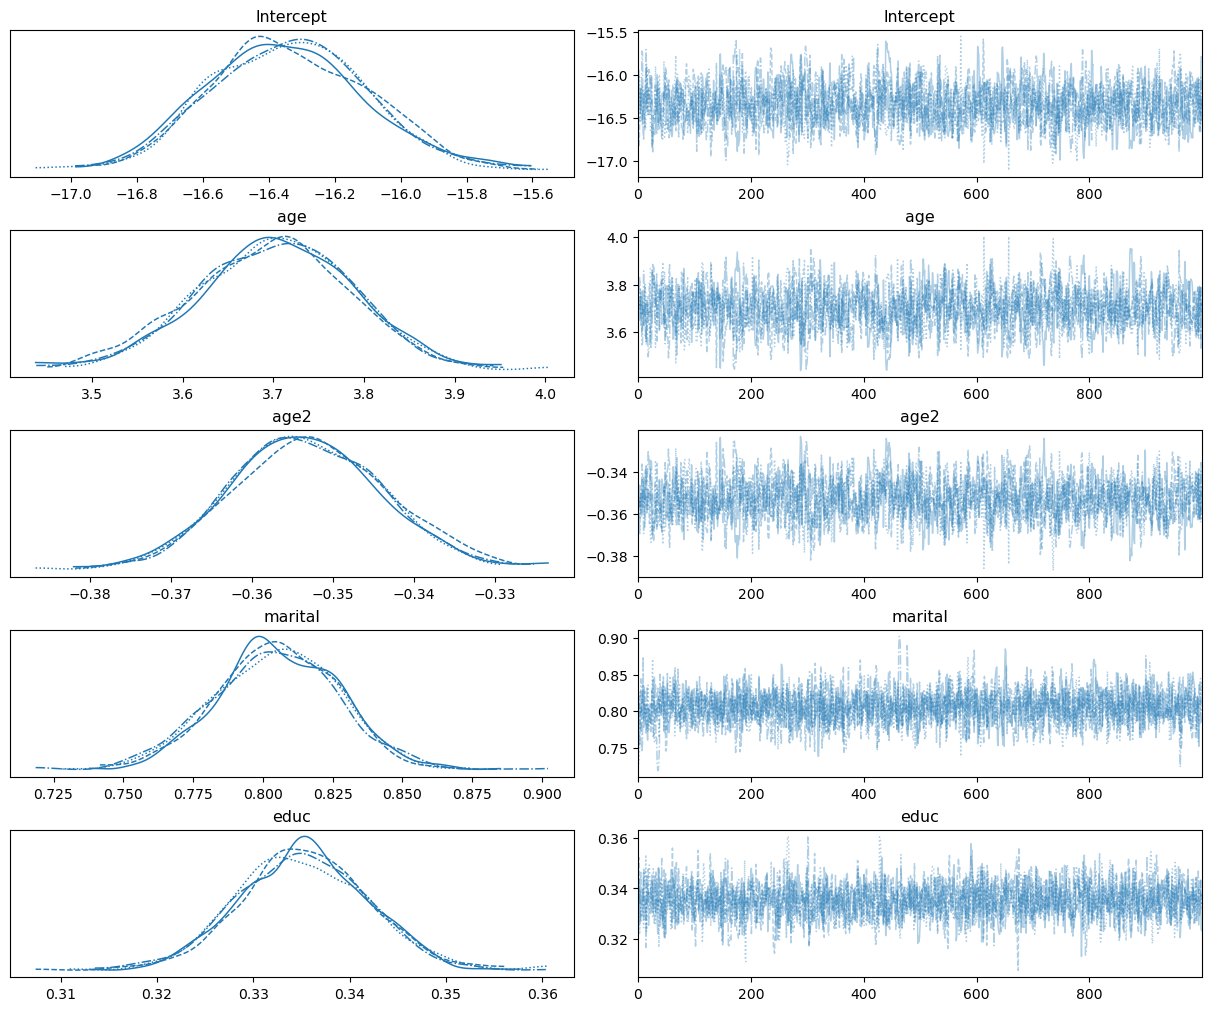

In [12]:


with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('income ~ age + age2 + marital + educ ', data, family = pm.glm.families.Binomial())
    trace = pm.sample(1000)
    
az.plot_trace(trace);

<Figure size 900x700 with 0 Axes>

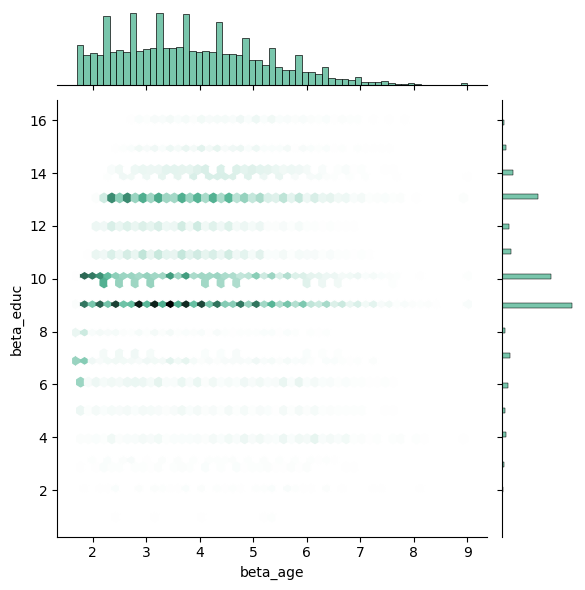

In [23]:
plt.figure(figsize=(9, 7))
seaborn.jointplot(data, x = "age", y="educ", kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ");

Итак, влияют ли возраст и образование на вероятность заработать больше, чем 50К? 

Чтобы ответить на этот вопрос мы покажем, что вероятность получить больше 50K меняется с возрастом и семейным положением для нескольких уровней образования. 

PyMC3 дает нам удобный способ построить апостериорное прогнозирующее распределение. Нам нужно передать функции линейную модель и набор точек для оценки. Мы перейдем к трем различным линейным моделям: одна с образованием == 12 (законченная средняя школа), одна с образованием == 16 (окончание бакалавриата) и одна с образованием == 19 (трехгодичная аспирантура).

c:\Users\anzel\anaconda3\envs\envpymc\lib\site-packages\pymc3\plots\posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


NameError: name 'mlines' is not defined

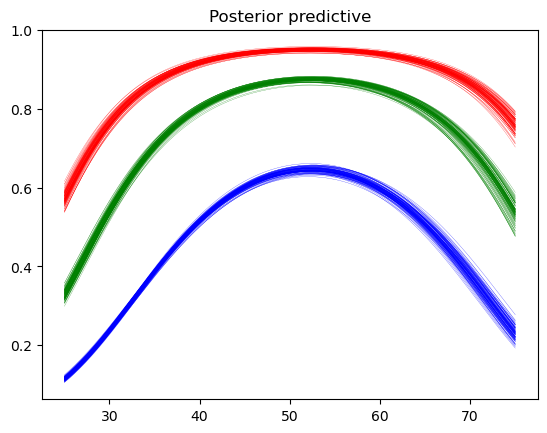

In [15]:
def lm_full(trace, age, education, marital):
    shape = np.broadcast(age, education, marital).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age/10., education, marital]])
    
    return 1 / (1 + np.exp(-(trace['Intercept'] + 
                             trace['age']*x_norm[0] + 
                             trace['age2']*(x_norm[0]**2) +
                             trace['educ']*x_norm[1] +
                             trace['marital']*x_norm[2])))

lm = lambda x, samples: lm_full(samples, x, 12., 4.)
lm2 = lambda x, samples: lm_full(samples, x, 16., 4.)
lm3 = lambda x, samples: lm_full(samples, x, 19., 4.)


pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm, samples=100, color='blue', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm2, samples=100, color='green', alpha=.8)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25,75,1000), lm=lm3, samples=100, color='red', alpha=.8)

blue_line = mlines.Line2D(["lm"], [], color="b", label="High School Education")
green_line = mlines.Line2D(["lm2"], [], color="g", label="Bachelors")
red_line = mlines.Line2D(["lm3"], [], color="r", label="Grad School")
plt.legend(handles=[blue_line, green_line, red_line], loc="lower right")
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show();

Каждая кривая показывает, насколько вероятность заработать больше, чем 50K меняется с возрастом. Красная кривая представляет 19 лет образования, зеленая кривая представляет 16 лет образования, а синяя кривая представляет 12 лет образования. Для всех трех уровней образования вероятность заработка более 50 тысяч долларов увеличивается с возрастом примерно до 60 лет, когда вероятность начинает снижаться. Обратите внимание, что каждая кривая немного размыта. Это потому, что мы фактически строим 100 различных кривых для каждого уровня образования. Каждая кривая является результатом нашего апостериорного распределения. Поскольку кривые в некоторой степени полупрозрачны, мы можем интерпретировать темные узкие участки кривой как места, где у нас низкая неопределенность, а светлые, расширенные участки кривой - как места, где у нас есть несколько более высокая неопределенность в отношении значений наших коэффициентов.

In [16]:
pm.summary(trace)

c:\Users\anzel\anaconda3\envs\envpymc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-16.340,0.235,-16.761,-15.899,0.007,0.005,1175.0,1656.0,1.0
age,3.701,0.086,3.540,3.858,0.003,0.002,1060.0,1538.0,1.0
age2,-0.353,0.009,-0.370,-0.335,0.000,0.000,1063.0,1602.0,1.0
marital,0.805,0.022,0.765,0.849,0.000,0.000,2257.0,2054.0,1.0
educ,0.335,0.007,0.324,0.348,0.000,0.000,2239.0,2210.0,1.0


## Сравнение с логистической регрессией

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(data[['age', 'educ',  'age2', 'marital']], data['income'])

LogisticRegression()

In [18]:
lr.intercept_

array([-16.26445812])

In [19]:
pd.DataFrame(lr.coef_[0], index=['age', 'educ',  'age2', 'marital'])

,0
age,3.669533
educ,0.335039
age2,-0.349695
marital,0.803746
